# MixUp 코드 설명 및 시각화
### 실제 적용된 코드를 분석해보자

In [ ]:
import torch
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

## MixUp 함수는 아래와 같다.
### input은 np.array 타입의 배치 단위로 입력된 이미지들이고,
### target은 배치단위의 true label
### alpha는 베타분포를 따르는 lambda를 뽑기 위한 np.random.beta의 인자이다.


In [ ]:
def mixup_aug(input, target, alpha=1.0):
    lambda_ = np.random.beta(alpha, alpha) # np.random.beta -> 두 개의 인자를 받아 베타분포를 따르는 랜덤수를 뽑음

    batch_size = input.size(0)
    index = torch.randperm(batch_size) # 0 ~ (batch_size-1)의 랜덤한 정수 순열(리스트)을 뽑음

    mixed_input = lambda_ * input + (1 - lambda_) * input[index, :]
    labels_a, labels_b = target, target[index]

    return mixed_input, labels_a, labels_b, lambda_


def mixuploss(criterion, pred, labels_a, labels_b, lambda_):
    return lambda_ * criterion(pred, labels_a) + (1 - lambda_) * criterion(pred, labels_b)

### index는 사진을 섞어주기 위한 정수 순열(리스트)이다.
### 두 개의 사진을 섞을 때 서로 다른 사진을 섞는다.
### 사진의 배치 순서를 바꿔 줄 때 배치 순서를 정해주는 게 index이다.

In [ ]:
index=torch.randperm(32)
index

tensor([16, 14,  4, 29, 11,  6, 20, 17, 27, 26,  5, 13, 24,  1, 25, 22, 19, 31,
         2,  0, 28, 15,  3,  7, 30, 18, 21, 23, 10,  9, 12,  8])

## 예시를 통해 index로 이미지의 배치순서를 바꾸는 법을 알아보자.
### 10x10 사이즈의 RGB 3채널의 이미지를 넣었고 batch size는 32라고 가정하자 (=사진 32장이 입력)

### 실제로 input은 배치사이즈의 numpy타입으로 넘어온다.
        마스크 분류에서 배치사이즈 이미지의 shape은 (32,3,512,384)

In [ ]:
print(index)

In [ ]:
# 예시) 10x10, RGB 3채널의 32개 이미지가 input으로 입력된다.
input = torch.range(1,9600)
input = torch.Tensor.int(input)
input = torch.reshape(input, (32,3,10,10)) # 10x10 사이즈의 이미지.
input

<ipython-input-14-55d5be083df4>:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  input = torch.range(1,9600)


tensor([[[[   1,    2,    3,  ...,    8,    9,   10],
          [  11,   12,   13,  ...,   18,   19,   20],
          [  21,   22,   23,  ...,   28,   29,   30],
          ...,
          [  71,   72,   73,  ...,   78,   79,   80],
          [  81,   82,   83,  ...,   88,   89,   90],
          [  91,   92,   93,  ...,   98,   99,  100]],

         [[ 101,  102,  103,  ...,  108,  109,  110],
          [ 111,  112,  113,  ...,  118,  119,  120],
          [ 121,  122,  123,  ...,  128,  129,  130],
          ...,
          [ 171,  172,  173,  ...,  178,  179,  180],
          [ 181,  182,  183,  ...,  188,  189,  190],
          [ 191,  192,  193,  ...,  198,  199,  200]],

         [[ 201,  202,  203,  ...,  208,  209,  210],
          [ 211,  212,  213,  ...,  218,  219,  220],
          [ 221,  222,  223,  ...,  228,  229,  230],
          ...,
          [ 271,  272,  273,  ...,  278,  279,  280],
          [ 281,  282,  283,  ...,  288,  289,  290],
          [ 291,  292,  293,  ...

In [ ]:
# 사진의 배치를 위에서 선언한 index의 순서대로 바꿔준다.
# input 출력과 input[index,:]의 출력을 비교해보면 index값에 따라 순서가 바뀜음 알 수 있다.
input[index,:]

tensor([[[[4801, 4802, 4803,  ..., 4808, 4809, 4810],
          [4811, 4812, 4813,  ..., 4818, 4819, 4820],
          [4821, 4822, 4823,  ..., 4828, 4829, 4830],
          ...,
          [4871, 4872, 4873,  ..., 4878, 4879, 4880],
          [4881, 4882, 4883,  ..., 4888, 4889, 4890],
          [4891, 4892, 4893,  ..., 4898, 4899, 4900]],

         [[4901, 4902, 4903,  ..., 4908, 4909, 4910],
          [4911, 4912, 4913,  ..., 4918, 4919, 4920],
          [4921, 4922, 4923,  ..., 4928, 4929, 4930],
          ...,
          [4971, 4972, 4973,  ..., 4978, 4979, 4980],
          [4981, 4982, 4983,  ..., 4988, 4989, 4990],
          [4991, 4992, 4993,  ..., 4998, 4999, 5000]],

         [[5001, 5002, 5003,  ..., 5008, 5009, 5010],
          [5011, 5012, 5013,  ..., 5018, 5019, 5020],
          [5021, 5022, 5023,  ..., 5028, 5029, 5030],
          ...,
          [5071, 5072, 5073,  ..., 5078, 5079, 5080],
          [5081, 5082, 5083,  ..., 5088, 5089, 5090],
          [5091, 5092, 5093,  ...

## mixup_aug를 다시 한 번 보자.

In [ ]:
alpha = 1.0
lambda_ = np.random.beta(alpha, alpha) # 베타분포는 0~1의 값을 갖는다.
lambda_

0.015580919235879486

In [ ]:
batch_size = input.size(0)
batch_size

32

# mixed_input 설명
### mixed_input은 lambda를 곱한 input 이미지와 (1-lambda)를 곱한 input[index,:]이미지를 더한다.

- 우연히 같은 이미지끼리 겹칠 수도 있다.
- 예를 들어,index가 아래와 같다면 4번 batch는 4번 인덱스 그대로 자리하기 때문에 같은 이미지로 mixup을 하게 된다.

        tensor([7, 21,  0, 12, 4, 18, 10, 27, 25, 16,  
                1, 31, 28, 15, 2, 22, 26, 29, 19,  5,  
                6, 30, 14, 20, 3, 17,  8, 11, 24, 13,
                23, 9])

In [ ]:
mixed_input = lambda_ * input + (1 - lambda_) * input[index, :]
mixed_input

tensor([[[[3341.3010, 3342.3008, 3343.3010,  ..., 3348.3010, 3349.3008,
           3350.3010],
          [3351.3010, 3352.3008, 3353.3010,  ..., 3358.3010, 3359.3010,
           3360.3008],
          [3361.3010, 3362.3008, 3363.3010,  ..., 3368.3010, 3369.3010,
           3370.3008],
          ...,
          [3411.3008, 3412.3010, 3413.3010,  ..., 3418.3010, 3419.3008,
           3420.3010],
          [3421.3008, 3422.3010, 3423.3010,  ..., 3428.3010, 3429.3008,
           3430.3010],
          [3431.3008, 3432.3010, 3433.3010,  ..., 3438.3010, 3439.3008,
           3440.3010]],

         [[3441.3010, 3442.3008, 3443.3010,  ..., 3448.3010, 3449.3008,
           3450.3010],
          [3451.3010, 3452.3008, 3453.3010,  ..., 3458.3010, 3459.3010,
           3460.3008],
          [3461.3010, 3462.3008, 3463.3010,  ..., 3468.3010, 3469.3010,
           3470.3008],
          ...,
          [3511.3008, 3512.3010, 3513.3008,  ..., 3518.3010, 3519.3008,
           3520.3010],
          [3521.30

## 18개의 class들을 갖는데, batch사이즈가 32이므로 target의 length는 32이다.

In [ ]:
target = torch.Tensor([ 3, 15, 11,  4,  6,  8,  9, 10,  5,  7,
                       16, 17, 14,  2, 13, 12,  0,  1, 2,  8,
                        13, 14,  5,  7,  9, 9, 17,  1, 12,  0,
                        15, 14, 11,  4,  3,  6])

In [ ]:
labels_a, labels_b = target, target[index]
labels_a  # lambda와 곱한 이미지의 정답 label

tensor([ 3., 15., 11.,  4.,  6.,  8.,  9., 10.,  5.,  7., 16., 17., 14.,  2.,
        13., 12.,  0.,  1.,  2.,  8., 13., 14.,  5.,  7.,  9.,  9., 17.,  1.,
        12.,  0., 15., 14., 11.,  4.,  3.,  6.])

In [ ]:
labels_b  # (1-lambda)와 곱한 이미지의 정답 label

tensor([ 0., 13.,  6.,  0., 17.,  9., 13.,  1.,  1., 17.,  8.,  2.,  9., 15.,
         9.,  5.,  8., 14., 11.,  3., 12., 12.,  4., 10., 15.,  2., 14.,  7.,
        16.,  7., 14.,  5.])

# mixuploss 뜯어보기
### criterion은 손실 함수인데, 여기서는 cross-entropy-loss라고 하자.
### pred는 모델에서 결과로 나온 예측값 $\hat{y}$ 이다.


In [ ]:
def mixuploss(criterion, pred, labels_a, labels_b, lambda_):
    return lambda_ * criterion(pred, labels_a) + (1 - lambda_) * criterion(pred, labels_b)

## 먼저 0~255의 값으로 이루어진 이미지의 값을 건들 시 어떻게 이미지가 변하는 지 알아보자.

## 이미지는 3개의 차원(R,G,B)의 픽셀로 이루어져있다.
## RGB는 0값이 어둡고, 255값으로 갈수록 밝다.

## 만약에 모든 픽셀값에 0.7를 곱하면 0.7배만큼 어두워진다.(명도가 낮아짐, 투명해진다고도 볼 수 있다.)






In [ ]:
# 두 개의 이미지를 가져오자.
image_path = '/content/drive/MyDrive/aitech6/week6/dataset/train/images/001131_female_Asian_22/incorrect_mask.jpg'
image_path2 = '/content/drive/MyDrive/aitech6/week6/dataset/train/images/001063_female_Asian_60/normal.jpg'
image = Image.open(image_path)
image2 = Image.open(image_path2)

In [ ]:
# PIL 객체로 가져온 이미지를 픽셀 값을 변경해주기 위해 numpy로 바꿔준다.
image_np = np.array(image.convert('RGB'))
image_np2 = np.array(image2.convert('RGB'))

image_np.shape

(512, 384, 3)

In [ ]:
image_np_lambda = image_np * 0.7       # 첫 번째 이미지에 0.7배 명도를 낮춘다.
image_np_lambda2 = image_np2 * 0.3     # 두 번째 이미지에 0.3배 명도를 낮춘다.

image_np_lambda = np.asarray(image_np_lambda, dtype='int')
image_np_lambda2 = np.asarray(image_np_lambda2, dtype='int')


Text(0.5, 0, '(1-lambda) = 0.3')

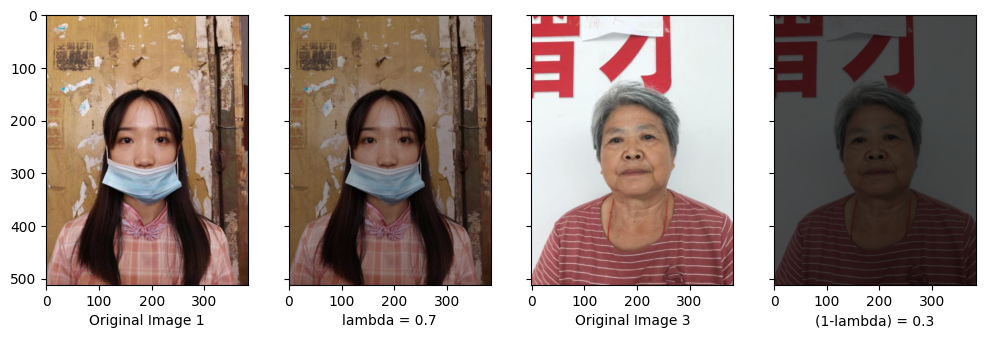

In [ ]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(image_np)
axes[0].set_xlabel('Original Image 1')
axes[1].imshow(image_np_lambda)
axes[1].set_xlabel('lambda = 0.7')
axes[2].imshow(image_np2)
axes[2].set_xlabel('Original Image 3')
axes[3].imshow(image_np_lambda2)
axes[3].set_xlabel('(1-lambda) = 0.3')

## 다시 mixed_input을 보면 명도값을 lambda배한 이미지와 (1-lambda)배한 이미지를 더한다.
## 시각화를 위해 255를 초과하는 픽셀값은 255로 보정한다

In [ ]:
# mixed_input = lambda_ * input + (1 - lambda_) * input[index, :]

# def mixuploss(criterion, pred, labels_a, labels_b, lambda_):
#     return lambda_ * criterion(pred, labels_a) + (1 - lambda_) * criterion(pred, labels_b)

In [ ]:
mixed_image = image_np_lambda + image_np_lambda2
mixed_image = np.where(mixed_image > 255, 255, mixed_image) # 255 초과 픽셀을 255로 보정.
mixed_image

array([[[203, 182, 126],
        [208, 180, 124],
        [215, 170, 121],
        ...,
        [153, 139, 141],
        [153, 139, 141],
        [153, 139, 141]],

       [[205, 183, 128],
        [211, 182, 129],
        [214, 172, 121],
        ...,
        [153, 138, 140],
        [153, 139, 140],
        [153, 139, 140]],

       [[206, 182, 128],
        [213, 184, 129],
        [212, 172, 122],
        ...,
        [153, 138, 140],
        [153, 138, 140],
        [153, 139, 140]],

       ...,

       [[188, 139, 133],
        [195, 146, 141],
        [191, 143, 137],
        ...,
        [ 91,  51,  44],
        [ 88,  48,  41],
        [ 87,  46,  39]],

       [[187, 136, 131],
        [191, 140, 136],
        [191, 144, 138],
        ...,
        [ 85,  48,  40],
        [ 86,  49,  41],
        [ 85,  48,  40]],

       [[187, 134, 131],
        [185, 135, 131],
        [189, 143, 136],
        ...,
        [ 84,  47,  39],
        [ 87,  50,  42],
        [ 87,  50,  42]]

Text(0.5, 0, 'Mixed image')

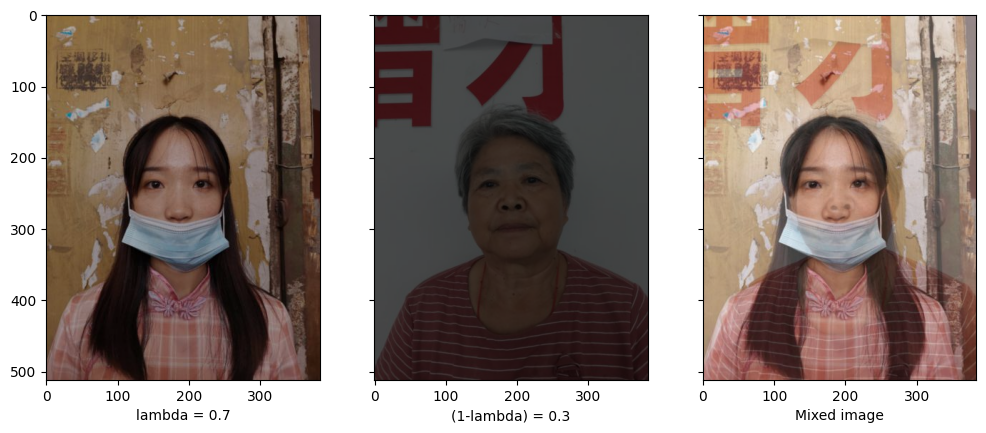

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(image_np_lambda)
axes[0].set_xlabel('lambda = 0.7')
axes[1].imshow(image_np_lambda2)
axes[1].set_xlabel('(1-lambda) = 0.3')
axes[2].imshow(mixed_image)
axes[2].set_xlabel('Mixed image')